# Create Project

In [1]:
#import libraries 
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer


## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

# Global/local importance tools
import joblib
import shap
from sklearn.inspection import permutation_importance
from lime.lime_tabular import LimeTabularExplainer

# ## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
plt.style.use(('ggplot','tableau-colorblind10'))

## Functions

In [2]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

## Load the Joblib Files

In [3]:
# load the joblib file
loaded_joblib= joblib.load('best-models2.joblib')
loaded_joblib.keys()


dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'RandomForestRegressor'])

In [4]:
# save the objects
X_train = loaded_joblib['X_train']
y_train = loaded_joblib['y_train']
X_test = loaded_joblib['X_test']
y_test = loaded_joblib['y_test']
preprocessor = loaded_joblib['preprocessor']
lin_reg = loaded_joblib['LinearRegression']
rf_reg = loaded_joblib['RandomForestRegressor']

In [5]:
## Get feature names from already-fit preprocessor
feature_names = preprocessor.get_feature_names_out()


## Use the preprocessor to transform X_train and X_test
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          index=X_train.index,
                          columns=feature_names)

X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                         index=X_test.index,
                          columns=feature_names)
X_train_df.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2
3527,7.855,0.000000,38.3848,1997.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
7331,19.750,0.012499,188.0872,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
4003,10.195,0.000000,114.0860,1997.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
2737,6.480,0.033900,146.9076,1997.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0
3553,15.000,0.046375,122.8414,1997.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [6]:
#fit the preprocessor
preprocessor.fit(X_train_df,y_train)


ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CECCA258E0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001CECCA33400>)],
                  verbose_feature_names_out=False)

# Global Explanations

In [9]:
# Take a sample of the training data (nsampel=100, use random_state=SEED)
X_shap = shap.sample(X_train_df, nsamples = 100,random_state=SEED)
X_shap.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2
6516,8.51,0.016176,192.1478,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
6981,13.10,0.075564,168.1158,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2634,11.80,0.107037,220.3772,2004.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6508,17.10,0.054197,83.5566,2004.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2048,10.50,0.041388,40.1164,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [10]:
# Take a sample of the training data (nsampel=100, use random_state=SEED)
X_shap = shap.sample(X_train_df, nsamples = 100,random_state=SEED)
X_shap.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2
6516,8.51,0.016176,192.1478,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
6981,13.10,0.075564,168.1158,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2634,11.80,0.107037,220.3772,2004.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
6508,17.10,0.054197,83.5566,2004.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2048,10.50,0.041388,40.1164,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [11]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap

6516    1937.4780
6981    2005.3896
2634    4447.5440
6508    1860.2452
2048     849.5608
          ...    
6981    2005.3896
8420    1867.5690
2579    1584.6040
8264    3705.1770
4114     309.5970
Name: Item_Outlet_Sales, Length: 100, dtype: float64

In [12]:
#get the shape
X_shap.shape


(100, 30)

## Explainer

In [13]:
# Instantiate a Model Explainer with the model
explainer =shap.TreeExplainer(rf_reg)
explainer

In [15]:
## Getting the shap values
shap_values = explainer.shap_values(X_shap,y_shap,check_additivity=False)
type(shap_values)

numpy.ndarray

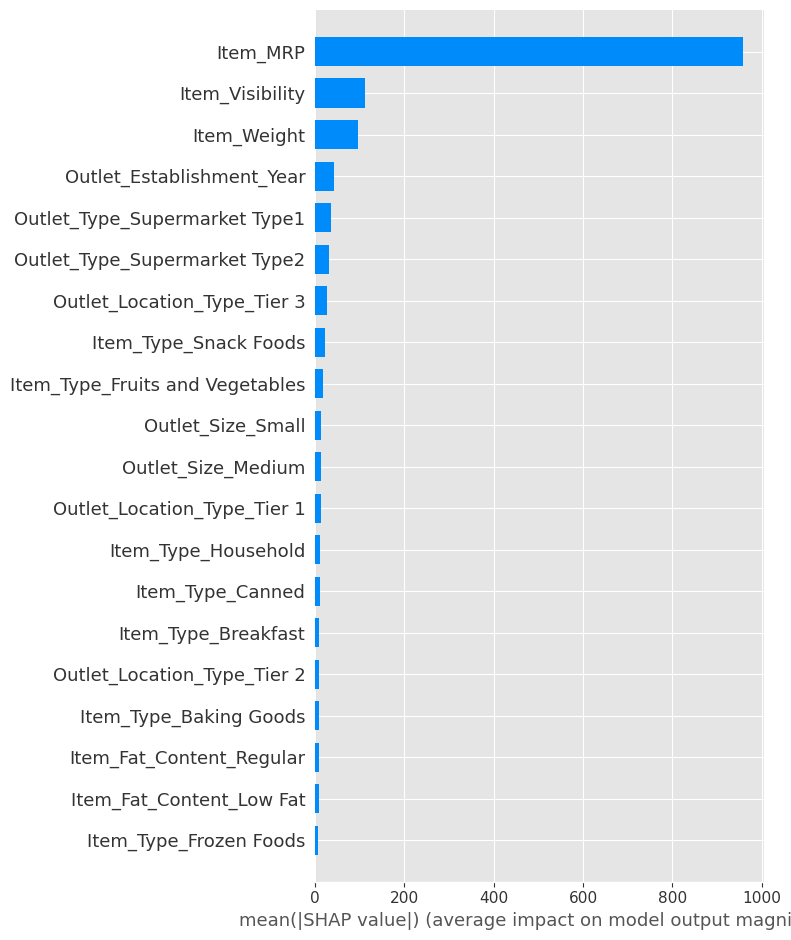

In [16]:
## create a summary plot (bar version)
shap.summary_plot(shap_values, features = X_shap, plot_type='bar')


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


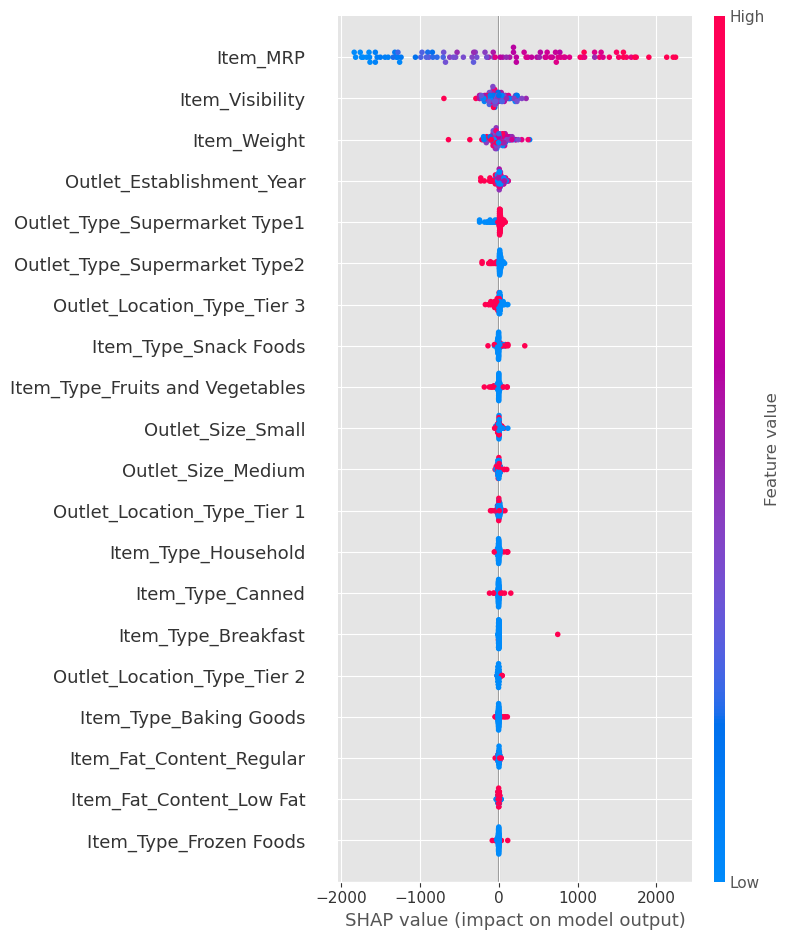

<Figure size 640x480 with 0 Axes>

In [17]:
## create a summary plot (dot/default version)
shap.summary_plot(shap_values, features = X_shap)
plt.savefig('Images/global_local_summary_plot.png')

#### Top 3 Important Features:
- Item MRP: The higher item MRP the more likely the model will predict a higher Item Outlet Sale
- Item  Visbility: the higher the visibility decreases the likelihood of predicting sales. 
-Item Weight: the higher the weight decreases the likelihood of predicting sales

# Individual Explanations

In [31]:
# initialize javascript:
shap.initjs()


## High Visibility 

In [20]:
## Making a vers of shap vars with 0-based integer index 
# so what it matches the index for the shap_vallues
## Making a vers of shap vars with 0-based integer index 
# so what it matches the index for the shap_vallues
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()


,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,...,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2
0,8.51,0.016176,192.1478,2009.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0
1,13.10,0.075564,168.1158,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,11.80,0.107037,220.3772,2004.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,17.10,0.054197,83.5566,2004.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,10.50,0.041388,40.1164,2004.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [19]:
# what is the max/range 
X_shap_local['Item_Visibility'].describe()

count    100.000000
mean       0.053334
std        0.041307
min        0.000000
25%        0.022452
50%        0.047238
75%        0.074638
max        0.179077
Name: Item_Visibility, dtype: float64

In [21]:
## saving the index of visibility deaths
idx_vis = X_shap_local['Item_Visibility'].idxmax()
idx_vis

87

In [26]:
# checking the feature values for selected example
X_shap_local.iloc[idx_vis]

Item_Weight                           6.17
Item_Visibility                       0.18
Item_MRP                             94.38
Outlet_Establishment_Year         1,997.00
Item_Fat_Content_Low Fat              0.00
Item_Fat_Content_Regular              1.00
Item_Type_Baking Goods                0.00
Item_Type_Breads                      0.00
Item_Type_Breakfast                   0.00
Item_Type_Canned                      0.00
Item_Type_Dairy                       0.00
Item_Type_Frozen Foods                0.00
Item_Type_Fruits and Vegetables       0.00
Item_Type_Hard Drinks                 0.00
Item_Type_Health and Hygiene          0.00
Item_Type_Household                   0.00
Item_Type_Meat                        1.00
Item_Type_Others                      0.00
Item_Type_Seafood                     0.00
Item_Type_Snack Foods                 0.00
Item_Type_Soft Drinks                 0.00
Item_Type_Starchy Foods               0.00
Outlet_Size_High                      0.00
Outlet_Size

In [27]:
## what was the visibility?
y_shap_local.iloc[idx_vis]

1342.2528

# LIME

In [26]:
## Create a lime explainer with X_shap_local with regression as the mode
lime_explainer =LimeTabularExplainer(
    training_data=X_shap_local.values,  
    feature_names=X_shap_local.columns,
   mode='regression'
)
lime_explainer

In [50]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[idx_vis],
                                      rf_reg.predict)
exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


# Interpretation 
- The predicted sales value is 316.27.
- Orange signifies the positive impact and blue signifies the negative impact of that feature on the target. 
- Positive impact on sales prediction 
 -  item type (meat), location 3, and frozen foods 
- Top 3 Negative impact on sales prediction
 -  Item MRP, Breakfast, Snack Foods 


# Force Plot for Item Visibility

In [49]:
## plotting example force plot for Visibility
shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[idx_vis],
               features=X_shap_local.iloc[idx_vis])


## Interpretation
- In this case, item type meat has  a positive impact on the prediction. Outlet size medium and supermarket type 2 also have positive impact on predicting sales. Two  features  have a negative impact on the prediction. These features Item MRP and  visibility. 

# Second Explanation

## High Visibillity

In [35]:
## saving the index of Item_MRP
idx_high_MRP = X_shap_local['Item_MRP'].idxmax()
idx_high_MRP

15

In [36]:
# checking the feature values for selected example
X_shap_local.iloc[idx_high_MRP]

Item_Weight                          19.850000
Item_Visibility                       0.005243
Item_MRP                            266.188400
Outlet_Establishment_Year          1999.000000
Item_Fat_Content_Low Fat              1.000000
Item_Fat_Content_Regular              0.000000
Item_Type_Baking Goods                0.000000
Item_Type_Breads                      0.000000
Item_Type_Breakfast                   0.000000
Item_Type_Canned                      0.000000
Item_Type_Dairy                       1.000000
Item_Type_Frozen Foods                0.000000
Item_Type_Fruits and Vegetables       0.000000
Item_Type_Hard Drinks                 0.000000
Item_Type_Health and Hygiene          0.000000
Item_Type_Household                   0.000000
Item_Type_Meat                        0.000000
Item_Type_Others                      0.000000
Item_Type_Seafood                     0.000000
Item_Type_Snack Foods                 0.000000
Item_Type_Soft Drinks                 0.000000
Item_Type_Sta

In [37]:
## what was the actual Item_MRP
y_shap_local.iloc[idx_high_MRP]

3179.8608

In [39]:
## plotting example force plot for Item_MRP (from rf)
shap.force_plot(explainer.expected_value, 
                shap_values=shap_values[idx_high_MRP],
               features=X_shap_local.iloc[idx_high_MRP])

- In this case, feature 'Item MRP' and 'Outlet Size small' have a positive impact on the prediction, while 'Item Weight' and 'Item Visibility' have a negative impact on the prediction.

In [57]:
## Create a lime explainer with X_shap_local with regression as the mode
lime_explainer =LimeTabularExplainer(
    training_data=X_shap_local.values,  
    feature_names=X_shap_local.columns,
   mode='regression'
)
lime_explainer

In [47]:
## Use the lime explainer to explain the selected example used above 
# Creating plot


fig = lime_explainer.explain_instance(X_shap_local.loc[idx_high_MRP],
                                      rf_reg.predict)
fig.show_in_notebook()
plt.savefig('Images/high_mrp_LIMEB2.png');

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


<Figure size 640x480 with 0 Axes>

#### The predicted sales value is 260.93
  - Orange signifies the positive impact and blue signifies the negative impact of that feature on the target.
 - Positive impact on sales prediction
Item MRP, Item Visibillity, and Supermarket type 2
 - Negative impact on sales prediction
Starchy Foods, Hard Drinks, and Baking Goods